In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pulses import RadarPulseGenerator, CommPulseGenerator
import torch
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e5), device=device)
dt = t[1] - t[0]
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5         # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval
Q = 256 #Number of Pulses in one Pulse train
T_PRI = T
carrier_freq = 800e6

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadar = RadarPulseGenerator(t, T=T, device=device)

radar_pulse = myRadar.LFM_pulse(B) * np.sqrt(1e4) #normalize power to unity (1Watt)
radar_pulse_power = myRadar.power_calc(radar_pulse)
print(10*np.log10(radar_pulse_power.cpu().numpy()))

N0 = 10**(-120/10)
MN = int(200)
distance = 200
velocities = torch.logspace(1, 3, 10)
est_velocities = torch.zeros((MN, len(velocities)))
crlb_velocities = torch.zeros(len(velocities))
for idx, velocity in enumerate(velocities):
    print(f'------>Progress:{(idx+1)/len(velocities)*100}\r\nTesting Velocity={velocity}')
    est_velocities[:, idx] = myRadar.montecarlo_doppler_estimation_slow_time(radar_pulse, N0, distance, velocity, carrier_freq, 3e8, Q, T_PRI, MN)
    print(f'Mean value->{torch.mean(est_velocities[:, idx])}, \t Variance->{torch.var(est_velocities[:, idx])}')

# --- Modified Plotting Section ---
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plotting on the primary (left) y-axis
ax1.set_title('Estimation Variance vs. Velocities', fontsize=16)
ax1.set_xlabel(r'Velocities ($m/s$)', fontsize=12)
ax1.set_ylabel(r'Variance ($\(m/s\)^2$)', fontsize=12)
ax1.grid(which='both', linestyle=':')
ax1.plot(velocities, torch.var(est_velocities, dim=0))

fig.tight_layout()
plt.savefig("crlb_vs_distance_with_snr.pdf", bbox_inches='tight')

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pulses import RadarPulseGenerator, CommPulseGenerator
import torch
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e5), device=device)
dt = t[1] - t[0]
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5         # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval
Q = 256 #Number of Pulses in one Pulse train
T_PRI = T
carrier_freq = 800e6

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadar = RadarPulseGenerator(t, T=T, device=device)

radar_pulse = myRadar.LFM_pulse(B) * np.sqrt(1e4) #normalize power to unity (1Watt)
radar_pulse_power = myRadar.power_calc(radar_pulse)
print(10*np.log10(radar_pulse_power.cpu().numpy()))

N0 = 10**(-120/10)
MN = int(200)
distance = 400
velocity = 1000
fd = 2 * velocity / 3e8 * carrier_freq
td = 2 * distance / 3e8
fd = 1e5
td = 40e-6
noise = np.sqrt(N0/2) * torch.randn_like(radar_pulse, dtype=torch.complex128)
rx_signal = myRadar.make_delay(radar_pulse, td) * torch.exp(1j*2*np.pi*fd*t) + noise
mf_output = torch.fft.ifftshift(torch.fft.ifft(torch.fft.fft(rx_signal) * torch.conj(torch.fft.fft(radar_pulse)))) * dt
tau0_hat = t[torch.argmax(torch.abs(mf_output))] - t[-1]/2
print(tau0_hat)
print((tau0_hat + fd * T / B) * 3e8 / 2)

max_v = torch.zeros(len(t))
for idx,tt in tqdm(enumerate(t)):
    term1 = rx_signal*torch.exp(-1j*2*np.pi*B/T*(tt)*t)*torch.exp(-1j*np.pi*B/T*(t**2))
    term2 = radar_pulse*torch.exp(-1j*np.pi*B/T*(t**2))
    mf_output2 = torch.fft.ifftshift(torch.fft.ifft(torch.fft.fft(term1) * torch.fft.fft(torch.conj(term2)))) * torch.exp(-1j*2*np.pi*B/T*(t**2)) * dt
    tau1_hat = t[torch.argmax(torch.abs(mf_output2))] - t[-1]/2
    max_v[idx] = torch.max(torch.abs(mf_output2))
    # plt.plot(t.cpu(), torch.abs(mf_output2).cpu())
    # print(tau1_hat)

cuda
4.3488213e-05
tensor(3.0001e-05, device='cuda:0')
tensor(6000.1201, device='cuda:0')


100000it [08:07, 205.06it/s]


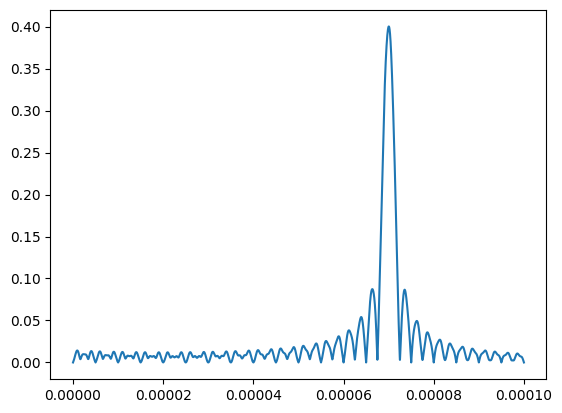

In [6]:
plt.plot(t.cpu(), max_v)

cuda
4.3488213e-05
tensor(3.0001e-05, device='cuda:0')
tensor(4.0001e-05, device='cuda:0')


100000it [02:35, 643.35it/s]


tensor(4.0000e-05, device='cuda:0')

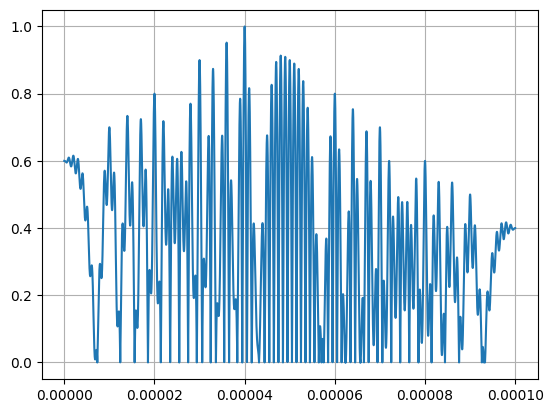

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from pulses import RadarPulseGenerator, CommPulseGenerator
import torch
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e5), device=device)
dt = t[1] - t[0]
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5         # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval
Q = 256 #Number of Pulses in one Pulse train
T_PRI = T
carrier_freq = 800e6

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadar = RadarPulseGenerator(t, T=T, device=device)

radar_pulse = myRadar.LFM_pulse(B) * np.sqrt(1e4) #normalize power to unity (1Watt)
radar_pulse_power = myRadar.power_calc(radar_pulse)
print(10*np.log10(radar_pulse_power.cpu().numpy()))

N0 = 10**(-100/10)
MN = int(200)
distance = 400
velocity = 1000
fd = 2 * velocity / 3e8 * carrier_freq
fd = 1e5
td = 2 * distance / 3e8
td = 40e-6
noise = np.sqrt(N0/2) * torch.randn_like(radar_pulse, dtype=torch.complex128)
rx_signal = myRadar.make_delay(radar_pulse, td) * torch.exp(1j*2*np.pi*fd*t) + noise
mf_output = torch.fft.ifftshift(torch.fft.ifft(torch.fft.fft(rx_signal) * torch.conj(torch.fft.fft(radar_pulse)))) * dt
tau0_hat = t[torch.argmax(torch.abs(mf_output))] - t[-1]/2
print(tau0_hat)
print((tau0_hat + fd * T / B))

H2 = torch.zeros(len(t))
for idx, tt in tqdm(enumerate(t)):
    term1 = rx_signal
    term2 = torch.roll(radar_pulse, idx)
    term3 = torch.exp(-1j*2*np.pi*B/T*(tt-tau0_hat)*t)
    H2[idx] = torch.sum(term1*torch.conj(term2)*term3)*dt

plt.plot(t.cpu(), torch.abs(H2))
plt.grid()

t[torch.argmax(torch.abs(H2))]
